Example 1: Identifying switch regions in KRAS
=============================================


In [2]:
import os

import numpy as np
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
import sklearn.metrics

from GWProt import GW_protein, stress_comparison, pymol_protein_viewer


KRAS (Kirsten Rat Sarcoma) is a signaling protein involved in cell proliferation. In its off state, it is bound to guanosine diphosphate (GDP). In its on state, it is bound to guanosine triphosphate (GTP) and activates effector proteins that can bind to two flexible switch regions. Certain mutant forms of KRAS keep it in its on state, which can cause uncontrolled proliferation and lead to multiple types of cancer. Thus, mutant forms of KRAS are potential drug targets.

In this example, we consider 54 experimentally determined structures of KRAS and compare them using ``GWProt``. We will group them using the GW distance and see how that corresponds to different conformations of the switch regions. We will also see how the local geometric distortion (LGD) captures the switch regions.

This dataset consists of experimentally determined PDB files of KRAS retrieved from [RCSB](https://www.rcsb.org), including both wild type and several missense mutants. Ligands, ions, and small molecules (including potential drug candidates) have been removed for clarity. All proteins were truncated to amino acids 2-162 in the [canonical sequence](https://www.uniprot.org/uniprotkb/P01116/entry#sequences) as some had missing data beyond that range. Files with multiple chains on RCSB were split into separate files in this dataset.

The processed PDB files can be found in the following folder in the [GitHub repository](https://github.com/CamaraLab/GWProt/tree/main/docs/Examples/Example_Data/KRAS%20Proteins). We have copied the files to the following local folder:

In [ ]:
dir = "Examples/Example_Data/KRAS Proteins/"

We start by creating `GW_protein` objects for each protein structure:

In [ ]:
import GWProt.GW_protein
import os

protein_list = [GWProt.GW_protein.GW_protein.make_protein_from_pdb(pdb_file = os.path.join(dir, file))  for file in os.listdir(dir)]

We then initialize an `LGD_Comparison` object to compare these protein structures using GW and the local geometric distortion (LGD).
In this example, we store the transport plans in memory with `RAM = True`. This will use roughly 600 MB of memory. The amount of required memory grows quadratically in the number of proteins.

In [ ]:
import GWProt.lgd_comparison

A = GWProt.lgd_comparison.LGD_Comparison(prot_list = protein_list, RAM =  True)

We then run GW all-vs-all. On our computer with 16 parallel processes this takes 5 seconds. With a single process it takes around 40 seconds.

In [ ]:
# Run GW all-vs-all. Adjust 'processes' for your hardware.
A.GW_compute_lgd(processes = 16)

We can study how the conformation of KRAS changes depending on the ligand it is bound to. The original PDB files contain KRAS bound to GDP and to the GTP-analogues GNP, GCP, and GSP, which we have saved in a metadata file and now load.

In [ ]:
import csv

ligand_dict = {}
with open("Examples/Example_Data/KRAS Ligands.csv", 'r') as ligand_metadata:
    csvreader = csv.reader(ligand_metadata)
    for row in csvreader:
        ligand_dict[row[0]] = row[1]

ligand_list  = [ligand_dict[p.name] for p in protein_list]

For this visual analysis, we will create a UMAP plot from the GW distances:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from umap import UMAP

distance_matrix = A.get_GW_dmat()
reducer = UMAP(metric = 'precomputed', random_state=1)
embedding = reducer.fit_transform(distance_matrix)

plt.figure(figsize=(8, 8))
unique_ligands = np.unique(ligand_list)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_ligands)))

for ligand, color in zip(unique_ligands, colors):
    mask = np.array(ligand_list) == ligand
    plt.scatter(
        embedding[mask, 0],
        embedding[mask, 1],
        c=[color],
        s=7,
        label=ligand
    )

plt.legend(title="Ligand")
plt.show()


We can cluster the structural space:

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, n_init=10, random_state=1)
cluster_labels = kmeans.fit_predict(embedding)

plt.figure(figsize=(8, 8))
cmap = plt.cm.tab10

for cluster_id in range(4):
    mask = cluster_labels == cluster_id
    plt.scatter(
        embedding[mask, 0],
        embedding[mask, 1],
        s=10,
        c=[cmap(cluster_id)],   # one color per cluster
        label=f"Cluster {cluster_id}"
    )

plt.legend(title="Cluster")
plt.show()

Using pymol we can clearly see that these clusters reflect conformational differences between the proteins. In this image of switch region II we see that the four clusters take have distinct conformations. We note that clusters 0 and 3 are very close by both conformationationally and in the UMAP clustering, corresponding to the fact that they have they have low GW distances. 


![Example_Data/Images/Switch_Region_II.png](Example_Data/Images/Switch_Region_II.png)

In this image of switch region I we see that most GTP-analogue-bound proteins (blue) have similar conformations and most GDP-bound proteins (red, green, and purple) have similar conformations distinct from the GTP-analogue-bound ones. 

![Example_Data/Images/Switch_Region_I.jpg](Example_Data/Images/Switch_Region_I.jpg)

Along with the different types of ligands, mutations, different drug candidates, and batch effects could contribute to the different conformations.

Next we use `pymol_protein_viewer.show_proteins_with_values` to visualize the proteins and the LGD (local geometric distortion) levels of different residues in the proteins. `A.raw_lgd_dict` contains the LGD values of all the pairwise calculations, so we first average them for each protein.

In [ ]:
# Average LGD values for each protein
avg_lgd_dict =  stress_comparison.normalize_lgd_dict(A.raw_lgd_dict)
avg_lgd_list = [avg_lgd_dict[name] for name in A.name_list]

In [ ]:
# Visualize LGD values on structures using PyMOL
pymol_protein_viewer.show_proteins_with_values(
    infiles = [os.path.join(dir, file) for file in os.listdir(dir)],
    chain_ids = [file[5] for file in os.listdir(dir)],
    data_lists = avg_lgd_list,
    output_file = "Examples Data/Pymol Outputs/KRAS_LGD.pse" )

pm created


The PyMOL file we generated and saved to `KRAS_LGD.pse` can then be opened in a PyMOL GUI window. The switch I region is in the foreground at the upper left and the switch II region in the foreground right. We see that both have higher LGD values as indicated by the redder colors, whereas the non-switch regions have lower LGD as indicated by yellows.

![Example_Data/Images/KRAS_Stresses.png](Example_Data/Images/KRAS_Stresses.png)

Next we will test how well the LGD values can be used to predict the switch I and switch II regions. These regions do not have well-defined endpoints but we will choose to use residues 30-40 and 60-72 in the canonical indexing respectively. As these files do not contain all the residues, the switch regions are at indices 28-38 and 58-74 instead.

We display the precision-recall curve of a randomly selected protein and the mean average precision (area under precision-recall curve).

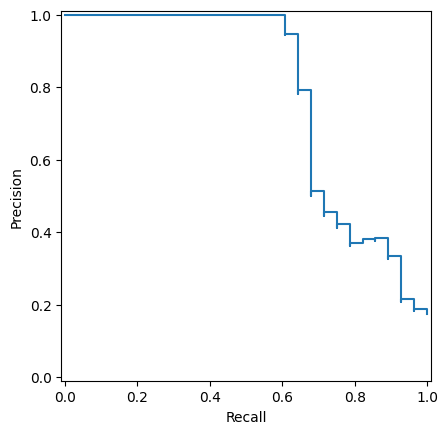

mean average precision = 0.8423611265528455


In [ ]:
switch_regions_dict = {p.name : [int(i in range(28,39) or i in range(58,75)) for i in range(161)] for p in protein_list}

# Precision-recall curve for a selected protein
p, r, _ = sklearn.metrics.precision_recall_curve(switch_regions_dict['5mla_A'], avg_lgd_dict['5mla_A'])
sklearn.metrics.PrecisionRecallDisplay(precision=p, recall=r).plot()
plt.show()
avg_precision_dict = stress_comparison.get_AP_scores(avg_lgd_dict, switch_regions_dict, upper=True)

print(f'mean average precision = {np.mean(list(avg_precision_dict.values()))}')

We can also compute the transferred LGD values with `raw_transferred_lgd`, which we then need to average with `normalize_lgd_dict`. Transferring uses the calculated transport plans to transpose the LGD values of one protein to another, and this is done in an all-to-all fashion. Generally, this improves accuracy. This computation takes under a second here but around 18 seconds when `RAM = False` due to file I/O.

In [ ]:
transferred_lgd = stress_comparison.normalize_lgd_dict(A.raw_transferred_lgd(avg_lgd_dict))

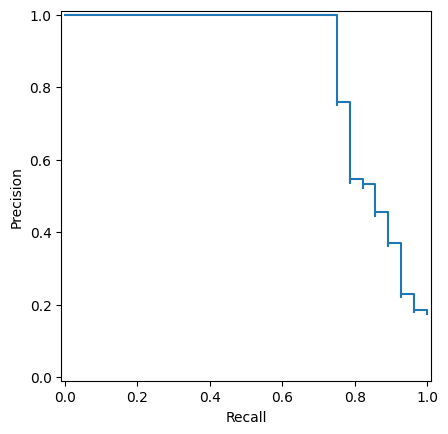

mean average precision = 0.8587374997410856


In [ ]:
# Precision-recall curve for transferred LGD values
p, r, _ = sklearn.metrics.precision_recall_curve(switch_regions_dict['5mla_A'], transferred_lgd['5mla_A'])
sklearn.metrics.PrecisionRecallDisplay(precision=p, recall=r).plot()
plt.show()

transferred_avg_precision_dict = stress_comparison.get_AP_scores(transferred_lgd, switch_regions_dict, upper=True)
print(f'mean average precision = {np.mean(list(transferred_avg_precision_dict.values()))}')